### Imports

In [238]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

import string
import re
import operator

### Loading the Dataset

In [239]:
# find all the txt files in the Data folder and appends them to inputs
inputs = []
for file in os.listdir("Data"):
    if file.endswith(".txt"):
        inputs.append(os.path.join("Data", file))
 
 
# concatanate all txt files in a file called merged_file.txt
with open('merged_file.txt', 'w') as outfile:
    for fname in inputs:
        with open(fname, encoding="utf-8", errors='ignore') as infile:
            outfile.write(infile.read())

In [240]:

# Strips white space in file, decodes into characters
with open('merged_file.txt') as f:
    text = f.readlines()
text = [x.strip() for x in text] 
print(text[:20])

text = open('merged_file.txt', 'rb').read().decode(encoding='utf-8')
# Number of characters in text
print ('Length of text: {} characters'.format(len(text)))

['[First scene opens with three Rangers riding through a tunnel, leaving the Wall, and going into the woods. (Eerie music in background) One Ranger splits off and finds a campsite full of mutilated bodies, including a child hanging from a tree branch. A birds-eye view shows the bodies arranged in a shield-like pattern. The Ranger rides back to the other two.]', 'WAYMAR ROYCE: What d’you expect? They’re savages. One lot steals a goat from another lot and before you know it, they’re ripping each other to pieces.', 'WILL: I’ve never seen wildlings do a thing like this. I’ve never seen a thing like this, not ever in my life.', 'WAYMAR ROYCE: How close did you get?', 'WILL: Close as any man would.', 'GARED: We should head back to the wall.', 'ROYCE: Do the dead frighten you?', 'GARED: Our orders were to track the wildlings. We tracked them. They won’t trouble us no more.', 'ROYCE: You don’t think he’ll ask us how they died? Get back on your horse.', '[GARED grumbles.]', 'WILL: Whatever did 

## Analyzing the Script data
Print statements taken from [Tensorflow's website](https://www.tensorflow.org/tutorials/text/text_generation)

In [241]:
# Removes tabs and carriage returns 
text = re.sub("[\r\t]", "", text)

In [242]:
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

#Finds unique characters in the script
vocab = sorted(set(text))
print('The Number of Unique chars : {}'.format(len(vocab)))

Length of text: 2474457 characters
The Number of Unique chars : 95


## Plotting Character Lines / Storing lines for characters

In [243]:
# Open the file in read mode
plot_text = open("merged_file.txt", "r")

# Create an empty dictionary
d = dict()

lines_dict = {
	"JON SNOW": "",
	"TYRION": "",
	"ARYA": "",
	"CERSEI": "",
	"JAIME":"",
	"DAENERYS": "",
	"WILL":""
}

# Loop through each line of the file
for line in plot_text:
	# removes some puncuation
	line = re.sub(r'[()\r\t]', "", line)
	# saves unchanged line for storing character lines
	unchanged_line = line
	# removes trailing and leading whitespace
	line = line.strip()
	# removes lowercase letters
	line = line.translate(line.maketrans("", "", string.ascii_lowercase))\

	name = ""
	
	i = 0
	# adds characters to name
	for char in line:
		if(char == ':'):
			break
		elif(char == '\n' or i > 20 or i >= len(line) - 1):
			name = ""
			break
		else:
			name = name + char
		i = i+1

	# decides whether to add to dictionary
	if(name != ""):
		# splits if separated by 2 or more spaces
		name = re.split(r'\s{2,}/', name)[0]

		if(name in d):
			d[name] = d[name] + 1
			if(name in lines_dict):
				lines_dict[name] += unchanged_line[len(name)+1:-1]

		elif(len(name.split()[0]) == 1):
			continue
		else:
			d[name] = 1

#  Removes bad entries in dictionary, such as EXT which means exit
errors = ['INT', 'EXT', 'MAN', 'CUT TO']
for key in errors:
	del d[key]

# Jon Snow was reffered to as both 'JON' and 'JON SNOW'  in the script so I combined them
d['JON'] = d['JON SNOW'] + d['JON']
del d['JON SNOW']

# turns dictionary into list of tuples sorted in descending order
sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)

# prints the ten characters with the most lines
print(sorted_d)
print(lines_dict)


[('TYRION', 1543), ('JON', 992), ('CERSEI', 899), ('JAIME', 864), ('DAENERYS', 854), ('SANSA', 710), ('ARYA', 669), ('DAVOS', 501), ('THEON', 411), ('SAM', 396), ('BRIENNE', 377), ('BRONN', 362), ('TYWIN', 350), ('BRAN', 326), ('VARYS', 321), ('STANNIS', 292), ('JORAH', 287), ('MARGAERY', 279), ('RAMSAY', 264), ('ROBB', 237), ('MELISANDRE', 226), ('TORMUND', 209), ('JOFFREY', 208), ('HOUND', 206), ('LITTLEFINGER', 205), ('GILLY', 197), ('OLENNA', 196), ('SHAE', 191), ('GENDRY', 186), ('MISSANDEI', 181), ('CATELYN', 180), ('YGRITTE', 171), ('DAARIO', 157), ('PODRICK', 152), ('YARA', 141), ('OBERYN', 132), ('BAELISH', 126), ('JAQEN', 119), ('TOMMEN', 119), ('SANDOR', 116), ('OSHA', 114), ('TALISA', 113), ('QYBURN', 113), ('GREY WORM', 113), ('THOROS', 102), ('MEERA', 99), ('SHIREEN', 93), ('SAMWELL', 92), ('ROOSE', 90), ('HIGH SPARROW', 89), ('BERIC', 84), ('EURON', 77), ('JOJEN', 76), ('LORAS', 75), ('HOT PIE', 67), ('BARRISTAN', 66), ('WALDER', 66), ('PYCELLE', 65), ('MANCE', 65), ('NE

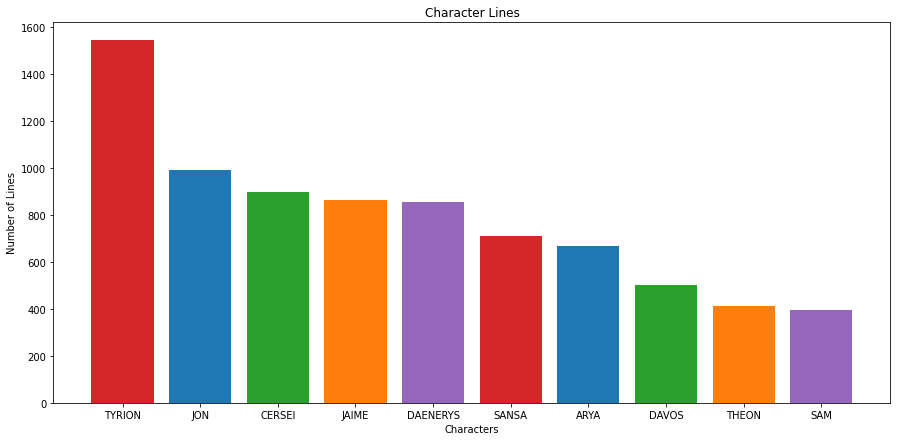

In [244]:
characters = []
num_lines = []
for character, lines in sorted_d[:10]:
    characters.append(character)
    num_lines.append(lines)

fig = plt.figure(figsize = (15, 7))
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple']
plt.bar(characters, num_lines, color = bar_colors)
plt.title('Character Lines')
plt.xlabel('Characters')
plt.ylabel('Number of Lines')
plt.show()

## Assign Identifiers

`vocab` is all of the unique characters in alphabetical order. Then, the `char_to_idx` will map each character to its index in the list giving it a unique identifier. `idx_to_char` will map each unique index to a specific char. This will help the model switch back and forth between between symbols and indices. 

In [245]:
# assigns each char in vocab to an index
char_to_idx = dict((c, i) for i, c in enumerate(vocab))
# assings each index to a char
idx_to_char = np.array(vocab)
# converts text from string to array of numbers
text_as_int = np.array([char_to_idx[c] for c in text])

In [246]:
# Prints out the first 10 characters and thier integer mappings
print('{')
for char,_ in zip(char_to_idx, range(10)):
    print('  {:4s}: {:3d},'.format(repr(char), char_to_idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  '&' :   5,
  "'" :   6,
  '(' :   7,
  ')' :   8,
  '*' :   9,
  ...
}


In [247]:
# Show how the first 13 characters from the text are mapped to integers
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'[First scene ' ---- characters mapped to int ---- > [54 33 64 73 74 75  1 74 58 60 69 60  1]


## Splitting up Text

### Creates trainable data for entire text

In [248]:
# Sequence length is the number of characters the model use for context
seq_length = 100

#examples_per_epochs = len(text)//(seq_length + 1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(''.join(idx_to_char[item.numpy()])))

'[First scene opens with three Rangers riding through a tunnel, leaving the Wall, and going into the w'
'oods. (Eerie music in background) One Ranger splits off and finds a campsite full of mutilated bodies'
', including a child hanging from a tree branch. A birds-eye view shows the bodies arranged in a shiel'
'd-like pattern. The Ranger rides back to the other two.]\nWAYMAR ROYCE: What d’you expect? They’re sav'
'ages. One lot steals a goat from another lot and before you know it, they’re ripping each other to pi'


In [249]:
# Creates input and target sequences which are misaligned by one
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

### Creates trainable data for each character in lines_dict

In [250]:
character_data = dict()

# 0. text_as_int
# 1. char_dataset
# 2. sequences
# 3. dataset

for key in lines_dict.keys():
    character_data[key] = [None,None,None,None]

# converts text to integers for individual characters
for ch in character_data.keys():
    lines = lines_dict[ch]
    buffer_size = 1000
    batch_size = 8

    character_data[ch][0] = np.array([char_to_idx[c] for c in lines])
    character_data[ch][1] = tf.data.Dataset.from_tensor_slices(character_data[ch][0])
    character_data[ch][2] = character_data[ch][1].batch(seq_length+1, drop_remainder=True)
    character_data[ch][3] = character_data[ch][2].map(split_input_target)
    character_data[ch][3] = character_data[ch][3].shuffle(buffer_size).batch(batch_size, drop_remainder=True)

In [251]:
# Gives an example of the what the input an output data look like
for input_example, target_example in  dataset.take(1):
    print ('Input data: ', repr(''.join(idx_to_char[input_example.numpy()])))
    print ('Target data:', repr(''.join(idx_to_char[target_example.numpy()])))

Input data:  '[First scene opens with three Rangers riding through a tunnel, leaving the Wall, and going into the '
Target data: 'First scene opens with three Rangers riding through a tunnel, leaving the Wall, and going into the w'


The input and output are zipped together. The following print statements were found online and demonstrate how the model compares the input and target sequences. 

In [252]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx_to_char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx_to_char[target_idx])))

Step    0
  input: 54 ('[')
  expected output: 33 ('F')
Step    1
  input: 33 ('F')
  expected output: 64 ('i')
Step    2
  input: 64 ('i')
  expected output: 73 ('r')
Step    3
  input: 73 ('r')
  expected output: 74 ('s')
Step    4
  input: 74 ('s')
  expected output: 75 ('t')


## The Model
1. **Sequential**

A feed-forward model that is ideal for a task such as text generation


2. **Embedding**

Stores all the words in the text as a vector. The "closeness" of each word to eachother in this vector helps the model learn about relationships between *words* intead of indiividual *characters*. 


3. **GRU**

A faster, and newer version of LSTM. Captures context with less computation allowing the model to train faster. The purpose of using the `glorot_uniform` initializer is to help mitigate the vanishing and exploding gradient problems during training. By setting the initial weights appropriately, it allows for more stable and efficient learning particularly in deep neural networks.


4. **Dense**

Output layer, a probability distribution of all possible characters. 

In [253]:
# Batch size
WHOLE_TEXT = 0

if(WHOLE_TEXT):
    BATCH_SIZE = 64
else:
    BATCH_SIZE = 8

# Goal is to shuffle the data
# Since the dataset is large, it will shuffle 10000 elements at a time so that is does not all need to be loaded in RAM
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<_BatchDataset element_spec=(TensorSpec(shape=(8, 100), dtype=tf.int32, name=None), TensorSpec(shape=(8, 100), dtype=tf.int32, name=None))>

In [254]:
# Length of the vocabulary in chars
vocab_size = len(vocab)
# dimensions of vector used to represent word
embedding_dim = 256
# Number of RNN units
# USED TO BE 1024
rnn_units = 512

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    # Recurrent NN architechture
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
    return model

In [255]:
# Builds the model
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [256]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (8, None, 256)            24320     
                                                                 
 gru_15 (GRU)                (8, None, 512)            1182720   
                                                                 
 dense_15 (Dense)            (8, None, 95)             48735     
                                                                 
Total params: 1,255,775
Trainable params: 1,255,775
Non-trainable params: 0
_________________________________________________________________


### Output Shape

Shows the **batch size**, **sequence length**, and **vocab size** respectivly

In [257]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(8, 100, 95) # (batch_size, sequence_length, vocab_size)


## Training the Model

1. Compile the model using adam optimizer and categorical crossentropy loss

2. Create a directory named "Training" that stores the weights after each epoch

3. use .fit to train the model

4. Load the best weights into the final model

In [258]:
# complies the model
# Loss function is categorical crossentropy since there are many classes (symbols) that the output could be
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits = True )
model.compile(optimizer = 'adam', loss = loss)

In [259]:
checkpoint_dir = 'Training'
character_name = "TYRION"
final_dir = os.path.join(checkpoint_dir, character_name)

if not os.path.exists(final_dir):
    # If it doesn't exist, create it
    os.makedirs(final_dir)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(final_dir, "ckpt")

# Saves the weights only if they perform better after each epoch
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
    )

Can run next cell to remove the directory containing the stored weights of the model if needed

In [260]:
# import shutil
# name_to_rem = "JON SNOW"
# shutil.rmtree(os.path.join(checkpoint_dir, name_to_rem))

In [ ]:
#training_data = dataset

training_data = character_data[character_name][3]
epochs = 35
history = model.fit(training_data, epochs=epochs, callbacks=[checkpoint_callback])

## Loading the weights

Since the weights are stored in a file, you can simply load them into the model without having to train it every time you load up the ipynb. 

In [262]:
# finds the filename of the latest checkpoint
tf.train.latest_checkpoint(checkpoint_dir)

'Training\\JON SNOW'

In [ ]:
# builds model
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
# loads best weights
model.load_weights(tf.train.latest_checkpoint(final_dir))
model.build(tf.TensorShape([1, None]))
model.summary()

## Plotting the Loss

Uses the plt library to plot the loss, or how far off the model's predictions are from the actual text. 

Text(0.5, 1.0, 'Metrics estimations')

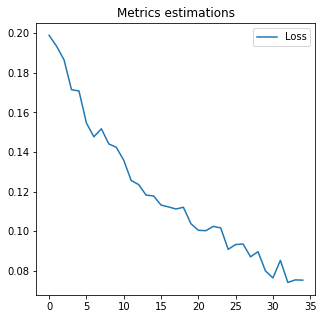

In [265]:
plt.figure(figsize=(5,5))
plt.plot(history.history['loss'], label='Loss')

plt.legend()
plt.title('Metrics estimations')

## Genereating text

In [266]:
def sample(preds, temperature=1.0):
    'Helper function to sample an index from a probability array.'
    preds = tf.squeeze(preds, 0) 
    preds = preds / temperature
    preds_id = tf.random.categorical(preds, num_samples=1)[-1,0].numpy()

    return preds_id

def predict_text(model, gen_length, temp, seed):
    generated = []

    x_pred = [char_to_idx[s] for s in seed]
    x_pred = tf.expand_dims(x_pred, 0)

    for i in range(gen_length):
        preds = model(x_pred)
        #print(preds)
        int_prediction = sample(preds, temp)
        char_prediction = idx_to_char[int_prediction]

        x_pred = tf.expand_dims([int_prediction], 0)

        generated.append(char_prediction)

    return (seed + ''.join(generated))

In [267]:
# length of generated output
gen_length = 1000
# Temperature (riskiness) of the predictions
temperature = 1
seed = "The White Walkers are coming, do we fight or do we run?"

print(predict_text(model, gen_length, temperature, seed))

The White Walkers are coming, do we fight or do we run?  All of them and you have a compliment, my lord. Has to leave? Oh, you have a crimed and your sword to please put the family less are wealth.  children true worse.  They’re entirely danying me, Pod, have you started coming. Well, want to she was anything brother. The impregness after as we you? There's no kind of father. No. What is there and a hand in coming to again? And the most possesses, Evhookedory om this few we'r all away in for you. And you can join us. Jusmine cloth at least. The proud Lord of the Around. Let's I seem to be we upout you wo deep luck for now of him in the world. I are their serviced catch as I can't. That's why Grey Worm and the other half a look with the high toice. Wish outside my closest plan on a dognt. It's the enemy spoken in the walls. It's not enough. They'll come someone who's never off to believe you? Dod Can Kingdoms and I know she will you important thing so him. I was wrong. One table, this i